In [3]:
import os
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras.regularizers import l2

import matplotlib.pyplot as plt
import numpy as np

In [4]:
INPUT_SHAPE = (256, 256, 3)

# DATA

### Loading the Datasets

In [ ]:
!tar -zxvf {'archive.tar.gz'}

In [6]:
train = tf.data.Dataset.load('Data/train.tfrecord')
test = tf.data.Dataset.load('Data/test.tfrecord')

### Testing the Model

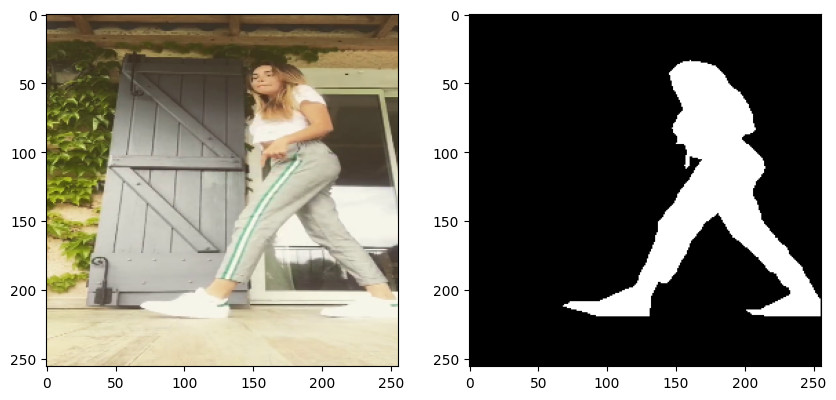

In [10]:
sample = test.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(tf.cast(sample[0][0]*255, dtype=tf.uint8))
ax[1].imshow(tf.cast(sample[1][0]*255, dtype=tf.uint8), cmap='gray')

# MODEL

### Building the Model

In [79]:
class ENet(Model):
    def __init__(self):
        super(ENet, self).__init__()

        self.model = self.build_model()


    # Builds the model
    def build_model(self):
        # Builds a Down Sampling Block
        def down_sampling(filters, inputs):
            x = Conv2D(filters, 3, (2,2), padding='same', kernel_initializer = "he_normal", use_bias=False)(inputs)
            y = MaxPooling2D((2,2), 2)(inputs)

            concat = Concatenate()([x, y])
            return ReLU()(concat)

        # Builds a Bottleneck Block
        def bottle_neck(filters, rate, inputs):
            x = inputs

            x = Conv2D(filters, (3,1), kernel_initializer="he_normal", padding="same", use_bias=False, dilation_rate=rate)(x)
            x = Conv2D(filters, (1,3), kernel_initializer="he_normal", padding="same", use_bias=False, dilation_rate=rate)(x)
            x = BatchNormalization()(x)
            x = ReLU()(x)

            x = Conv2D(filters, (3,1), kernel_initializer="he_normal", padding="same", use_bias=False, dilation_rate=rate)(x)
            x = Conv2D(filters, (1,3), kernel_initializer="he_normal", padding="same", use_bias=False, dilation_rate=rate)(x)
            x = BatchNormalization()(x)
            x = Add()([x, inputs])

            return ReLU()(x)


        # Initial Stage
        input = Input(shape=INPUT_SHAPE)
        x = down_sampling(13, input)

        x = down_sampling(16, x)
        x = bottle_neck(32, 1, x)

        x = down_sampling(32, x)
        x = bottle_neck(64, 2, x)
        x = bottle_neck(64, 4, x)
        x = bottle_neck(64, 8, x)
        x = bottle_neck(64, 8, x)
        x = bottle_neck(64, 4, x)
        x = bottle_neck(64, 2, x)

        x = Conv2DTranspose(32, 2, 2, kernel_initializer="he_normal", padding="same")(x)
        x = bottle_neck(32, 1, x)
        x = bottle_neck(32, 1, x)

        x = Conv2DTranspose(16, 2, 2, kernel_initializer="he_normal", padding="same")(x)
        x = bottle_neck(16, 1, x)

        out = Conv2DTranspose(1, 2, 2, kernel_initializer="he_normal", padding="same", activation='sigmoid')(x)
        return Model(inputs=input, outputs=out)


    # Saves the model
    def save(self, file_path):
        self.model.save(file_path)


    def call(self, inputs):
        return self.model(inputs, training=True)

In [ ]:
model = ENet()

### Optimizer and Loss Function

In [87]:
def dice_loss_func(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 -(2.0 * intersection + 1) / (union + 1)

def loss_func(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = dice_loss_func(y_true, y_pred)
    return binary_cross_entropy_loss + 3.0*dice_loss

In [ ]:
model.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

### Training the Model

In [ ]:
model.fit(train, epochs=50, validation_data=test)

### Testing the Model

In [50]:
sample = test.as_numpy_iterator().next()

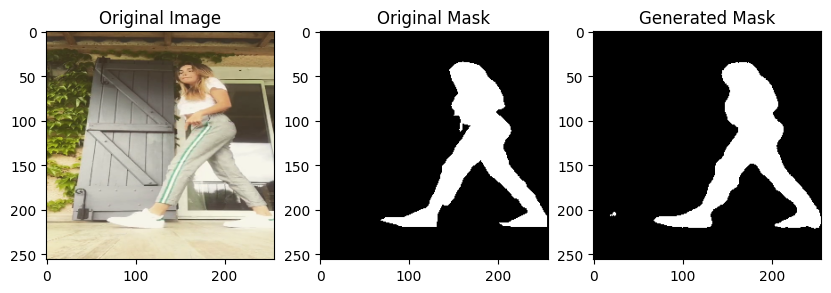

In [89]:
mask = model(sample[0])
mask = np.where(mask >= 0.2, 1, mask)
mask = np.where(mask < 0.2, 0, mask)


fig, ax = plt.subplots(ncols=3, figsize=(10,5))
ax[0].imshow(tf.cast(sample[0][0]*255, dtype=tf.uint8))
ax[0].set_title('Original Image')
ax[1].imshow(tf.cast(sample[1][0]*255, dtype=tf.uint8), cmap='gray')
ax[1].set_title('Original Mask')
ax[2].imshow(mask[0], cmap='gray')
ax[2].set_title('Generated Mask');

##### Removing the Background

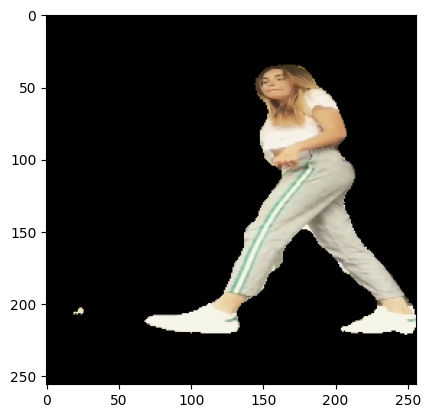

In [90]:
new = sample[0][0].copy()*255
density = 100
for row in range(new.shape[0]):
    for col in range(new.shape[1]):
        if mask[0][row][col] == 0 :
                new[row][col] = 0

plt.imshow(tf.cast(new, dtype=tf.uint8))

### Saving the Model

In [ ]:
model.save('E-NET.h5')